# 4.1 Нахождение линий

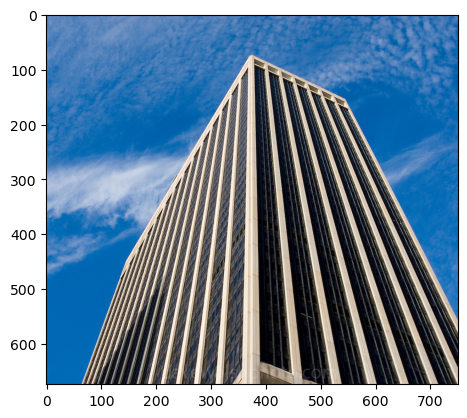

In [23]:
import random
from typing import Union

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, show, Circle
import numpy as np
import numpy.typing as npt

def get_image() -> np.array:
    dir = "images/"
    image = Image.open(dir + "MG-3713-manhattan-55-water-street-crop-dr.jpg")
    image_array = np.array(image)[:, :, :3]
    return image_array


def show_image(array: np.array, mode: Union[str, None] = 'Greys'):
    figure()
    imshow(array, cmap=mode)


show_image(get_image())

## Полутоновое изображение

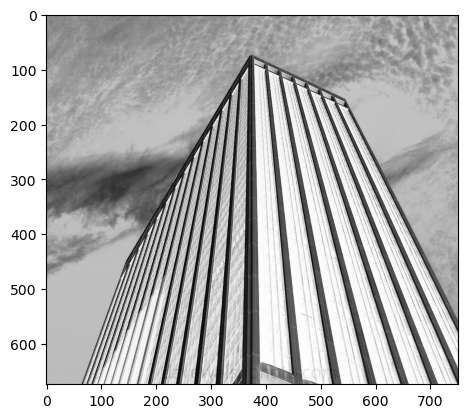

In [24]:
def get_halftone_image() -> np.array:
    image_array = get_image()
    mean = np.mean(image_array, axis=2, dtype=int)
    return mean

show_image(get_halftone_image())

## Шум

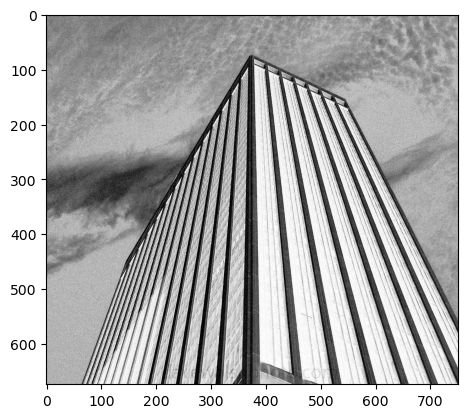

In [25]:
def get_noise_image(mean: float = 50, sigma: float = 5, data_type=float) -> np.array:
    halftone_image_array = get_halftone_image()
    return np.clip(np.array([np.array([pixel + random.gauss(mean, sigma) * random.randint(0, 1) // 3 for pixel in row], dtype=data_type)
                     for row in halftone_image_array]), 0, 255)

show_image(get_noise_image())

## Размытие Гаусса

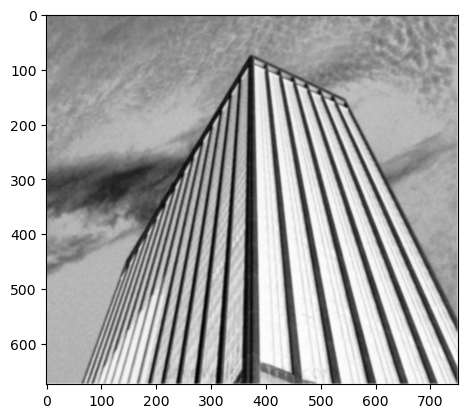

In [26]:
def filter_gauss(K_size, sigma, im):
    H, W = im.shape

    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad: pad + H, pad: pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y: y + K_size, x: x + K_size])
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out[pad: pad + H, pad: pad + W]

show_image(filter_gauss(8, 1.5, get_noise_image()))

## Фильтр Собеля

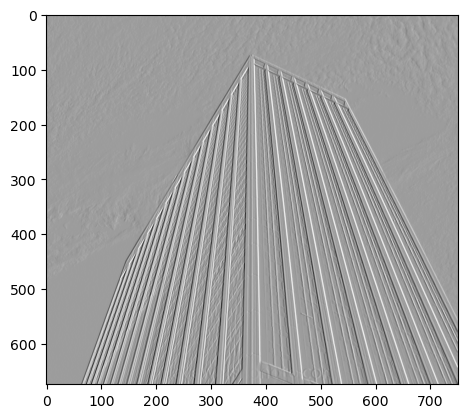

In [27]:
def filter_sobel(image) -> npt.NDArray[list[tuple[int, int]]]:
    H, W = image.shape

    out = np.zeros((H + 2, W + 2, 2), np.float64)
    out[1: 1 + H, 1: 1 + W, 0] = image.copy().astype(np.float64)
    out[0, 0, 0] = out[1, 1, 0]
    out[-1, 0, 0] = out[-2, 1, 0]
    out[0, -1, 0] = out[1, -2, 0]
    out[-1, -1, 0] = out[-2, -2, 0]
    out[1: 1 + H, 0, 0] = out[1: 1 + H, 1, 0]
    out[1: 1 + H, -1, 0] = out[1: 1 + H, -2, 0]
    out[0, 1: 1 + W, 0] = out[1, 1: 1 + W, 0]
    out[-1, 1: 1 + W, 0] = out[-2, 1: 1 + W, 0]

    Mx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
        dtype=int
    )
    My = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ],
        dtype=int
    )
    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[1 + y, 1 + x] = (np.sum(Mx * tmp[y: y + 3, x: x + 3, 0]), np.sum(My * tmp[y: y + 3, x: x + 3, 0]))
    return out[1: 1 + H, 1: 1 + W]


show_image(filter_sobel(get_halftone_image())[:, :, 0])

## Нахождение магнитуд и направлений

In [28]:
def get_magnitude(gradient_matrix: npt.NDArray) -> npt.NDArray[list[int]]:
    return np.sum(abs(gradient_matrix), axis=2)

def get_direction_degrees(gradient_matrix: npt.NDArray) -> npt.NDArray[list[float]]:
    return np.degrees(np.arctan2(gradient_matrix[:, :, 1], gradient_matrix[:, :, 0]))

def get_direction_in_45_step(gradient_matrix: npt.NDArray) -> npt.NDArray[list[int]]:
    degrees_matrix = get_direction_degrees(gradient_matrix)
    return np.rint(degrees_matrix % 360 / 45).astype(int) * 45

image = filter_gauss(8, 1, get_noise_image())
# image = get_halftone_image()
gradient_matrix = filter_sobel(image)
magnitude = get_magnitude(gradient_matrix)
direction = get_direction_in_45_step(gradient_matrix)

## Подавление немаксимумов

In [29]:
def _get_directions(current_angle: int, i: int, j: int) -> tuple[tuple[int, int], tuple[int, int]]:
        if current_angle in (0, 180, 360):
                return (i, j + 1), (i, j - 1)
        elif current_angle in (45, 225):
                return (i - 1, j + 1), (i + 1, j - 1)
        elif current_angle in (90, 270):
                return (i - 1, j), (i + 1, j)
        elif current_angle in (135, 315):
                return (i - 1, j - 1), (i + 1, j + 1)
        else:
            raise Exception


def maximum_suppression(magnitude: npt.NDArray[list[float]], direction: npt.NDArray[list[int]]):
    H, W = magnitude.shape

    for i in range(H):
        for j in range(W):
            if not magnitude[i][j]:
                continue
            directions = _get_directions(direction[i][j], i, j)
            if directions[0][0] < 0 or directions[0][0] == H or directions[0][1] < 0 or directions[0][1] == W:
                point_1_magnitude = 0
            else:
                point_1_magnitude = magnitude[directions[0][0]][directions[0][1]]
            if directions[1][0] < 0 or directions[1][0] == H or directions[1][1] < 0 or directions[1][1] == W:
                point_2_magnitude = 0
            else:
                point_2_magnitude = magnitude[directions[1][0]][directions[1][1]]
            if not (magnitude[i][j] > point_1_magnitude and magnitude[i][j] > point_2_magnitude):
                magnitude[i][j] = 0

maximum_suppression(magnitude, direction)

## Оператор Кэнни

In [30]:
def kenny_operator(suppressed_magnitude: npt.NDArray[list[float]]):
    Thigh, Tlow = 200, 100
    H, W = suppressed_magnitude.shape

    borders = np.zeros((H + 2, W + 2), bool)
    magnitude = borders.copy().astype(float)
    magnitude[1: 1 + H, 1: 1 + W] = suppressed_magnitude

    for i in range(H):
        for j in range(W):
            if suppressed_magnitude[i][j] <= Thigh or borders[i + 1, j + 1]:
                continue
            borders[i + 1, j + 1] = True
            temp_i, temp_j = i, j
            while True:
                temp_border = (magnitude[temp_i: temp_i + 3, temp_j: temp_j + 3] > Tlow) ^ borders[temp_i: temp_i + 3, temp_j: temp_j + 3]
                if temp_border.any():
                    temp_i += np.argwhere(temp_border)[-1][0] - 1
                    temp_j += np.argwhere(temp_border)[-1][1] - 1
                    borders[temp_i + 1, temp_j + 1] = True
                else:
                    break
    return borders[1: H + 1, 1: W + 1].astype(np.bool_)


image_after_kenny_operator = kenny_operator(magnitude)

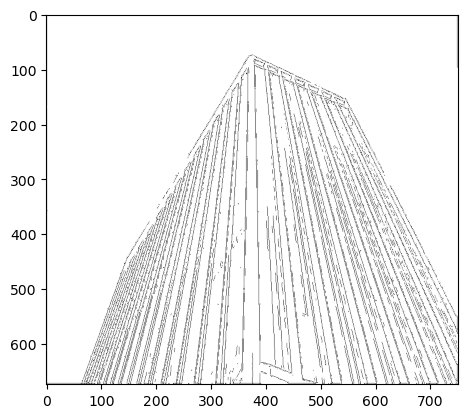

In [31]:
show_image(image_after_kenny_operator)

## Кумулятивная матрица

In [32]:
def hough_matrix(image, direction_in_degrees):
    H, W = image.shape

    ro_max = np.ceil(np.sqrt(H ** 2 + W ** 2)).astype(int)

    hough = np.zeros((ro_max, 360), dtype=int)

    ind = np.where(image == True)
    for y, x in zip(ind[0], ind[1]):
        direction = direction_in_degrees[y, x]
        theta = int(direction) % 360
        t = np.pi / 180 * theta
        ro = int(x * np.cos(t) + y * np.sin(t))
        hough[ro, theta] += 1

    return hough.astype(np.uint8)


## Подавление не максимумов

In [33]:
def hough_non_maximum_suppression(hough):
    ro_max, _ = hough.shape
    for y in range(ro_max):
        for x in range(360):
            x1 = max(x - 1, 0)
            x2 = min(x + 2, 360)
            y1 = max(y - 1, 0)
            y2 = min(y + 2, ro_max - 1)
            if np.max(hough[y1:y2, x1:x2]) == hough[y, x] and hough[y, x]:
                continue
            else:
                hough[y, x] = 0


In [34]:
def draw_line(image, hough):
    H, W, _= image.shape
    ro_max, _ = hough.shape

    out = image.copy()
    points = np.argsort(hough.reshape(-1))[::-1][:100]
    # обратная операция получения координат из одномерного массива
    # он ведь был (RxT)
    thetas = points % 360
    ros = points // 360

    for theta, ro in zip(thetas, ros):
        t = np.pi / 180 * theta

        for x in range(W):
            if np.sin(t):
                y = (-np.cos(t) * x + ro) / np.sin(t)
                y = int(y)
                if y >= H or y < 0:
                    continue
                out[y, x] = [0,255,255]
        for y in range(H):
            if np.cos(t):
                x = (-np.sin(t) * y + ro) / np.cos(t)
                x = int(x)
                if x >= W or x < 0:
                    continue
                out[y, x] = [0,0,255]

    return out.astype(np.uint8)


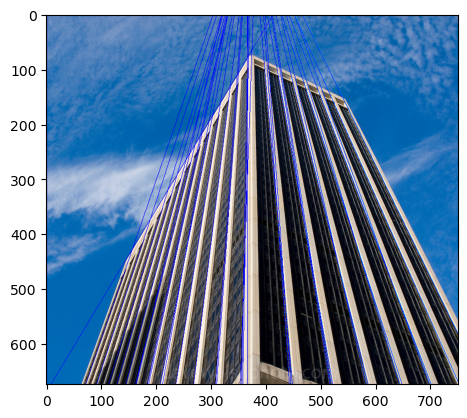

In [35]:
source_image = get_image()
hough = hough_matrix(image_after_kenny_operator, get_direction_degrees(gradient_matrix))
hough_non_maximum_suppression(hough)
image_with_lines = draw_line(source_image, hough)
show_image(image_with_lines)

# 4.2 Нахождение окружностей

In [14]:
def find_radius(center_x, center_y, x, y):
    return int(((x - center_x) ** 2 + (y - center_y) ** 2) ** .5)

In [15]:
def hough_matrix_circle(image, direction_in_45_step):
    H, W = image.shape

    r_max = np.ceil(np.sqrt(H ** 2 + W ** 2)).astype(int)

    hough = np.zeros((H, W, r_max), dtype=int)

    ind = np.where(image == True)
    for y, x in zip(ind[0], ind[1]):
        direction = direction_in_45_step[y, x]
        hough[y, x, 0] += 1
        step_in, step_out = _get_directions(direction, y, x)
        for s in step_in, step_out:
            step = s[0] - y, s[1] - x
            temp_x, temp_y = x, y
            while H > temp_y + step[0] >= 0 and W > temp_x + step[1] >= 0:
                r = find_radius(temp_x + step[1], temp_y + step[0], x, y)
                if r < r_max:
                    hough[temp_y + step[0], temp_x + step[1], r] += 1
                temp_x += step[1]
                temp_y += step[0]

    return hough


## Подавление немаксимумов с окружностями

In [16]:
def hough_circle_non_maximum_suppression(hough):
    H, W, R = hough.shape
    for y in range(H):
        for x in range(W):
            x1 = max(x - 1, 0)
            x2 = min(x + 2, W)
            y1 = max(y - 1, 0)
            y2 = min(y + 2, H - 1)
            for r in range(R):
                if np.max(hough[y1:y2, x1:x2, r]) == hough[y, x, r] and hough[y, x, r]:
                    continue
                # TODO: РАССМОТРЕТЬ СРЕЗ ПО R
                else:
                    hough[y, x, r] = 0

## Нахождение окружностей

In [20]:
def draw_circle(image, hough):
    H, W, R = hough.shape

    points = np.argsort(hough.reshape(-1))[::-1][:10]
    # обратная операция получения координат из одномерного массива
    # он ведь был (HxWxR)
    radiuses = points % R
    widths = (points // R) % W
    heights = points // R // W

    figure()
    for h, w, r in zip(heights, widths, radiuses):
        # print(h, w, r)
        c = Circle((h, w), radius=r, color='red')
        plt.gca().add_artist(c)
    imshow(image)


step1
step2
42 251 2
244 67 56
165 500 164
85 261 12
109 225 2
219 540 132
379 416 135
377 419 138
109 515 1
93 264 7


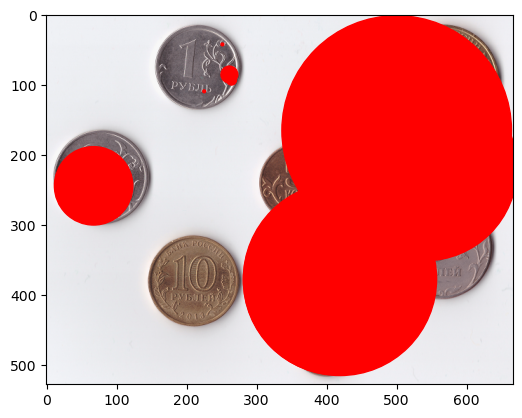

In [18]:
hough = hough_matrix_circle(image_after_kenny_operator, direction)
print('step1')
hough_circle_non_maximum_suppression(hough)
print('step2')
draw_circle(source_image, hough)